# Lyon Parking Analysis


The objective of this analysis is to use the data collected between April 2017 and August 2017 to classify the behavior of parking lots in the city of Lyon, France. 

After finishing an Android application during the 2016-2017 academic year at my University, I was too curious not to use the data obtained for some amazing project. All data was collected from https://data.grandlyon.com/, an open-data plataform of the Grand Lyon metropole which aims to encourage the citizen participation in the development of the city and the creation of new services. The methodology applied here was based on [Jake VanderPlas' analysis of Seattle Work Habits](http://jakevdp.github.io/blog/2015/07/23/learning-seattles-work-habits-from-bicycle-counts/).

There are two datasets corcerning the parking lots: 
     - a dataset containing the names, coordinates and other relevant static information about 1000 parkings in the city;
     - a dataset containing the real-time number of disponible places of 42 parking lots (this number has been increasing).

The data was stored in a SQL database and here we will be using Machine Learning methods from scikit-learn library to visualize and classify the parking lots.

Before going further, most of non-valuable information was removed from the .sql file. Some data concerning the number of disponible places were filled by "No data available" due to closure or maybe a problem in the communication between the database and the parking lot.

## The data

We'll analyse the real time data of 42 parkings, our objects of study. The information given is the number of disponible places for each ~5 minutes. Yet, as the total capacity of each object varies considerably, this greatly affects the number of arriving cars and the number of occupied parking places by hour.

It's more interesting to attach ourselves to the following question:

What moment does the parkings have their peak of arriving cars for each day?

We expect that the answer to this question, on the other hand, does not depend on the capacity.

Let's create a class that we'll use to manage each parking.

In [132]:
import time
import json
import urllib.request
import sqlite3
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#connecting to the sql file
conn =sqlite3.connect('parking20171024-16h.sqlite')
#creating a cursor
cursor = conn.cursor()

#each parking will be associated to an Parking object.
class Parking:
    
    def __init__(self,number):
        self.__state = []
        self.__time = []
        self.__capacity = 0
        self.__name = number
        
        #selecting all rows from the sql table
        cursor.execute("SELECT * from {}".format(number))
        data = cursor.fetchall()
        i = 0
        for row in data:
            dateString = row[1] #the index 0 of each row contains the moment of last update
            if i == 0:
                self.__capacity= int(row[3])
            try:
                if i>=0:
                     if len(self.__time)==0 or self.__time[-1] != datetime.strptime(dateString,'%Y-%m-%d %H:%M:%S'):
                        self.__time.append(datetime.strptime(dateString,'%Y-%m-%d %H:%M:%S'))
                        state = row[2].split(' ')[0] #because the data was in the format "xxx places diponibles"
                        if (state.isdigit()):
                            state = int(state)
                        else:
                            state = self.__state[-1]
                        self.__state.append(state)
            except  ValueError:
                continue
            i+=1
        return
            
    def getTimeTable(self):
        return self.__time
    
    def getStateTable(self):
        return self.__state
    
    def getCapacity(self):
        return self.__capacity
    
    def getPeakHours(self): 
        dateList = [] # the list of days that can be associated to a peak hour for a given Parking.
        peakHours = [] # the moment of peak in hours
        momentBefore = self.__time[3] #the first 2 rows were quite noisy
        availabilityBefore = self.__state[3]
        arrivingCars = 0
        maxValue =  0 #maxValue of arriving cars for each day (changes everytime we find an hour with more arriving cars than before)
        maxDelta = 0 #difference of disponible places for each row of the database.
        maxDeltaMinute = 0 #minute of maximum delta
        peakHour = None
        for i in range(4,len(self.__time)):
            moment  = self.__time[i]
            availability = self.__state[i]
            if moment.day != momentBefore.day and moment<datetime(2017,9,29,0,0,0): #the data after 29 september was also quite noisy
                if peakHour != None:
                    dateList.append(datetime(momentBefore.year,momentBefore.month,momentBefore.day))
                    peakHours.append(peakHour)
                maxValue = 0
                maxDelta = 0
                arrivingCars = 0       
            elif moment<datetime(2017,9,29,0,0,0):
                if moment.hour == momentBefore.hour:
                    if availability<availabilityBefore:
                        delta = availabilityBefore - availability
                        arrivingCars += delta
                        if delta>maxDelta:
                            maxDelta = delta
                            maxDeltaMinute = momentBefore.minute
                if moment.hour != momentBefore.hour:
                    #verify if momentBefore.hour corresponds to the peak hour
                    if arrivingCars>maxValue:
                        maxValue = arrivingCars                        
                        peakHour = momentBefore.hour + maxDeltaMinute/60
                    arrivingCars = 0
                    maxDelta = 0
            availabilityBefore = availability
            momentBefore = moment
        return (dateList,peakHours)
        
#unfortunately, some hard-coding was necessary. The tables had their names as the numbers in full in french.
parking_names = ['un','soixantedixneuf','deux','trois','quatre','cinq', 'six','sept','huit','dix','onze','douze','treize','quatorze','seize','dixhuit','dixneuf','vingt','vingtun','vingtdeux','vingttrois','vingtcinq','vingtsept','vingthuit','trenteneuf','quarante','quarante_un','quarantetrois','quarantequatre','quarantecinq','quarantesept','quarantehuit','quaranteneuf','cinquante','cinquantedeux','cinquantetrois','cinquante_quatre','cinquante_cinq', 'centcinq','centquatre','centsept','quatrevingtsept']
parking_numbers = [1,79,2,3,4,5,6,7,8,10,11,12,13,14,16,18,19,20,21,22,23,25,27,28,39,40,41,43,44,45,47,48,49,50,52,53,54,55,105,104,107,87]   
parkings = []
for name in parking_names:
    print(name)
    parkings.append(Parking(name))

un
soixantedixneuf
deux
trois
quatre
cinq
six
sept
huit
dix
onze
douze
treize
quatorze
seize
dixhuit
dixneuf
vingt
vingtun
vingtdeux
vingttrois
vingtcinq
vingtsept
vingthuit
trenteneuf
quarante
quarante_un
quarantetrois
quarantequatre
quarantecinq
quarantesept
quarantehuit
quaranteneuf
cinquante
cinquantedeux
cinquantetrois
cinquante_quatre
cinquante_cinq
centcinq
centquatre
centsept
quatrevingtsept


In [133]:
import pandas as pd

#Create a pandas table relating each state to one specific hour
(timeTable108,stateTable108) = Parking('centhuit').getPeakHours()
print(len(stateTable108))
df = pd.DataFrame({ 'Day':timeTable108,'108':stateTable108})
df.set_index('Day', inplace = True)
print('ok 108')
for i in range(len(parking_names)):
    print(df.shape)
    (timeTable,stateTable) = parkings[i].getPeakHours()
    print(len(stateTable))
    print(parking_names[i])
    dfTemp = pd.DataFrame({'Day':timeTable,parking_numbers[i]:stateTable})
    dfTemp.set_index('Day', inplace = True)
    df = pd.concat([df, dfTemp], axis=1)
df.head()

139
ok 108
(139, 1)
129
un
(140, 2)
140
soixantedixneuf
(140, 3)
120
deux
(140, 4)
129
trois
(140, 5)
129
quatre
(140, 6)
127
cinq
(140, 7)
126
six
(140, 8)
128
sept
(140, 9)
129
huit
(140, 10)
129
dix
(140, 11)
129
onze
(140, 12)
129
douze
(140, 13)
113
treize
(140, 14)
129
quatorze
(140, 15)
129
seize
(140, 16)
129
dixhuit
(140, 17)
129
dixneuf
(140, 18)
125
vingt
(140, 19)
128
vingtun
(140, 20)
129
vingtdeux
(140, 21)
129
vingttrois
(140, 22)
129
vingtcinq
(140, 23)
128
vingtsept
(140, 24)
129
vingthuit
(140, 25)
134
trenteneuf
(140, 26)
139
quarante
(140, 27)
139
quarante_un
(140, 28)
139
quarantetrois
(140, 29)
139
quarantequatre
(140, 30)
140
quarantecinq
(140, 31)
139
quarantesept
(140, 32)
135
quarantehuit
(140, 33)
140
quaranteneuf
(140, 34)
140
cinquante
(140, 35)
139
cinquantedeux
(140, 36)
98
cinquantetrois
(140, 37)
134
cinquante_quatre
(140, 38)
140
cinquante_cinq
(140, 39)
139
centcinq
(140, 40)
140
centquatre
(140, 41)
114
centsept
(140, 42)
139
quatrevingtsept


,108,1,79,2,3,4,5,6,7,8,...,49,50,52,53,54,55,105,104,107,87
Day,,,,,,,,,,,,,,,,,,,,,
2017-04-19,NaN,22.950000,21.483333,NaN,22.366667,21.633333,21.400000,21.400000,21.733333,21.300000,...,21.300000,22.900000,NaN,21.900000,NaN,21.300000,NaN,21.366667,NaN,NaN
2017-04-20,7.400000,6.233333,20.033333,10.133333,6.400000,12.500000,19.566667,20.250000,19.816667,20.066667,...,7.400000,7.233333,7.733333,8.250000,0.966667,8.950000,7.533333,7.666667,7.733333,13.566667
2017-04-21,7.866667,6.150000,20.566667,17.250000,6.016667,11.900000,20.566667,20.366667,19.900000,20.366667,...,7.633333,17.200000,7.700000,8.533333,0.633333,8.816667,8.000000,7.700000,7.566667,7.750000
2017-04-22,9.000000,8.816667,20.066667,16.150000,6.900000,14.150000,20.316667,20.566667,12.633333,13.150000,...,11.000000,16.366667,9.366667,8.533333,0.466667,9.600000,8.316667,10.066667,7.566667,16.700000
2017-04-23,14.066667,16.750000,1.066667,13.316667,13.150000,12.150000,11.750000,12.566667,12.400000,16.366667,...,13.366667,16.066667,10.000000,NaN,0.466667,14.733333,15.333333,11.566667,NaN,13.750000


In [134]:
df.shape

(140, 43)

In [135]:
df = df.dropna(0)
df.shape

(76, 43)

## Extracting information from the data

Our pandas table associates each index (a date) to 43 peak hours (one for each parking). It's possible to see this in an other way:

We can associate to each parking an peak hour for each day.

In [136]:
transposed = df.transpose()
#transposed = transposed.fillna(transposed.mean(1))
X = transposed.values
X.shape

(43, 76)

We now have 43 vectors of 77 dimensions as our data. 
We'll use a method called Principal Component Analysis (PCA) to project all these vectors in 2 dimensions so we can better visualize and analyse it. If you want to understand how PCA works, here's a good video: https://www.youtube.com/watch?v=_UVHneBUBW0

In [137]:
from sklearn.decomposition import PCA
Xpca = PCA(0.65).fit_transform(X)
Xpca.shape

(43, 3)

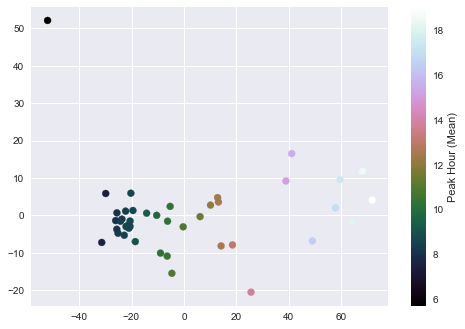

In [138]:
colors = X.mean(1)
plt.scatter(Xpca[:, 0], Xpca[:, 1], c=colors,
            cmap='cubehelix')
plt.colorbar(label='Peak Hour (Mean)');
plt.show()

We can start to see that the parking lots with peak hours near 17h tend to cluster, and also do the parkings with mean peak hour at 8 hours.

However, there's an outlier point at the top left of the image. We can use an Outlier Detection Method to remove it from out data and then use the PCA again.

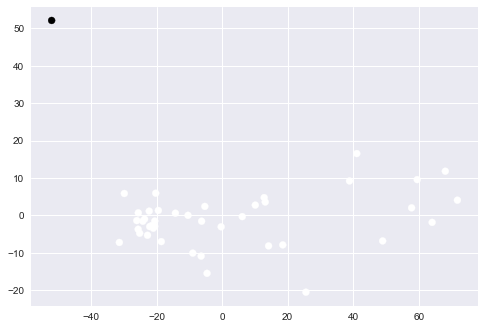

In [139]:
from sklearn import cluster, datasets, mixture,ensemble
import seaborn; seaborn.set()
isolationForest = ensemble.IsolationForest(n_estimators=(46-1), contamination = 0/46)

isolationForest.fit(Xpca)
outlierPrediction = isolationForest.predict(Xpca)

plt.scatter(Xpca[:, 0], Xpca[:, 1], c=outlierPrediction,cmap='cubehelix')
plt.show() 


In [140]:
transposed['Cluster'] = outlierPrediction
transposedIF = transposed.loc[transposed['Cluster'] == 1]
transposedIF.head()

Day,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00,2017-04-24 00:00:00,2017-04-25 00:00:00,2017-04-26 00:00:00,2017-04-27 00:00:00,2017-04-28 00:00:00,2017-04-29 00:00:00,2017-05-02 00:00:00,...,2017-07-19 00:00:00,2017-07-20 00:00:00,2017-07-21 00:00:00,2017-08-22 00:00:00,2017-08-23 00:00:00,2017-08-24 00:00:00,2017-08-25 00:00:00,2017-08-26 00:00:00,2017-08-28 00:00:00,Cluster
108,7.400000,7.866667,9.000000,7.400000,7.400000,7.250000,7.400000,7.950000,8.066667,7.65,...,7.783333,8.150000,7.683333,8.066667,8.016667,8.400000,7.450000,10.566667,7.400000,1
1,6.233333,6.150000,8.816667,6.066667,6.150000,6.066667,6.250000,6.250000,14.000000,15.50,...,6.183333,6.216667,6.216667,6.566667,10.066667,6.066667,6.450000,10.716667,6.183333,1
79,20.033333,20.566667,20.066667,12.133333,20.200000,12.400000,20.366667,20.500000,21.200000,12.45,...,20.783333,20.316667,20.783333,12.450000,12.900000,20.066667,20.616667,21.650000,12.233333,1
2,10.133333,17.250000,16.150000,14.166667,12.116667,11.866667,6.400000,12.333333,17.066667,13.75,...,8.850000,13.283333,0.750000,13.233333,15.733333,16.516667,15.350000,15.900000,10.066667,1
3,6.400000,6.016667,6.900000,9.066667,6.800000,6.500000,6.400000,12.000000,15.400000,12.65,...,6.050000,6.650000,0.150000,5.683333,10.566667,5.950000,5.566667,12.066667,6.066667,1


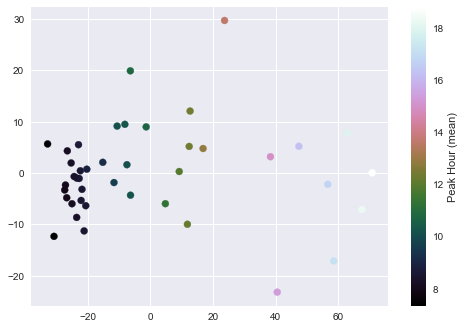

In [141]:

Xif = transposedIF.values
Xpcaif = PCA(0.8).fit_transform(Xif)

mean = Xif.mean(1)
plt.scatter(Xpcaif[:, 0], Xpcaif[:, 1], c=mean,
            cmap='cubehelix')
plt.colorbar(label='Peak Hour (mean)');
plt.show()

As we have only 43 points to plot, the image is not as clean as it could be. However, it's possible to see points with small values of peak hours clustering in the left, points with high values of peak hours clustering in the right and some others in between the two. We can try to separate the points in 3 different clusters. Let the machine speak for itself.

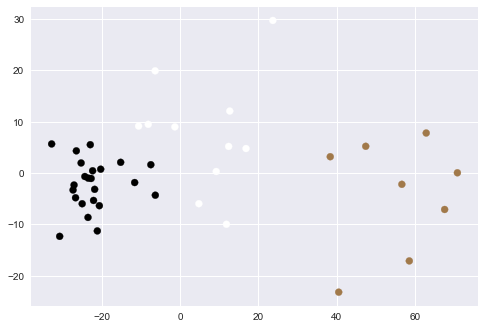

In [165]:

import warnings



from sklearn import cluster, datasets, mixture
import seaborn; seaborn.set()

nbClusters =  3
gmm = mixture.GaussianMixture(n_components=nbClusters, covariance_type='full')

with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            gmm.fit(Xpcaif)
            clusterPrediction = gmm.predict(Xpcaif)

plt.scatter(Xpcaif[:, 0], Xpcaif[:, 1], c=clusterPrediction,cmap='cubehelix')
plt.show() 


In [166]:
transposedIF['Cluster'] = clusterPrediction
#df = df.join(transposed['Cluster'], on=df.index, lsuffix ='_left', rsuffix = '_right')
transposedIF

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Day,2017-04-20 00:00:00,2017-04-21 00:00:00,2017-04-22 00:00:00,2017-04-24 00:00:00,2017-04-25 00:00:00,2017-04-26 00:00:00,2017-04-27 00:00:00,2017-04-28 00:00:00,2017-04-29 00:00:00,2017-05-02 00:00:00,...,2017-07-19 00:00:00,2017-07-20 00:00:00,2017-07-21 00:00:00,2017-08-22 00:00:00,2017-08-23 00:00:00,2017-08-24 00:00:00,2017-08-25 00:00:00,2017-08-26 00:00:00,2017-08-28 00:00:00,Cluster
108,7.400000,7.866667,9.000000,7.400000,7.400000,7.250000,7.400000,7.950000,8.066667,7.650000,...,7.783333,8.150000,7.683333,8.066667,8.016667,8.400000,7.450000,10.566667,7.400000,0
1,6.233333,6.150000,8.816667,6.066667,6.150000,6.066667,6.250000,6.250000,14.000000,15.500000,...,6.183333,6.216667,6.216667,6.566667,10.066667,6.066667,6.450000,10.716667,6.183333,0
79,20.033333,20.566667,20.066667,12.133333,20.200000,12.400000,20.366667,20.500000,21.200000,12.450000,...,20.783333,20.316667,20.783333,12.450000,12.900000,20.066667,20.616667,21.650000,12.233333,1
2,10.133333,17.250000,16.150000,14.166667,12.116667,11.866667,6.400000,12.333333,17.066667,13.750000,...,8.850000,13.283333,0.750000,13.233333,15.733333,16.516667,15.350000,15.900000,10.066667,2
3,6.400000,6.016667,6.900000,9.066667,6.800000,6.500000,6.400000,12.000000,15.400000,12.650000,...,6.050000,6.650000,0.150000,5.683333,10.566667,5.950000,5.566667,12.066667,6.066667,0
4,12.500000,11.900000,14.150000,9.400000,8.750000,9.366667,9.066667,10.566667,13.000000,12.316667,...,9.900000,9.250000,0.883333,8.400000,10.066667,12.316667,12.150000,11.400000,8.733333,0
5,19.566667,20.566667,20.316667,19.250000,19.400000,19.900000,20.166667,20.000000,16.366667,19.500000,...,19.883333,20.850000,1.483333,20.733333,19.150000,19.900000,20.183333,20.066667,19.900000,1
6,20.250000,20.366667,20.566667,9.816667,8.566667,1.316667,20.166667,20.400000,12.250000,12.250000,...,9.016667,9.183333,0.150000,8.400000,9.816667,8.900000,20.566667,20.483333,8.566667,2
7,19.816667,19.900000,12.633333,9.166667,20.066667,20.066667,12.566667,19.700000,11.000000,19.466667,...,12.483333,9.116667,0.050000,19.733333,19.016667,19.733333,20.183333,20.016667,9.650000,2
8,20.066667,20.366667,13.150000,20.066667,20.066667,19.833333,20.416667,20.066667,15.250000,19.250000,...,20.116667,20.516667,0.183333,19.900000,19.616667,20.733333,20.150000,20.733333,20.233333,1


## Visualizing the data

Is it reasonable to cluster the 42 parkings in 3 groups?
The following figure is the plot of the mean values of peak hours for each cluster for each day. Some parkings are more frequented in the night, some are more likely to have their peak hours near 8h and some near 13h. 

In [167]:
df.iloc[15:,:]

,108,1,79,2,3,4,5,6,7,8,...,49,50,52,53,54,55,105,104,107,87
Day,,,,,,,,,,,,,,,,,,,,,
2017-05-10,7.700000,6.200000,20.650000,9.416667,10.500000,9.116667,19.616667,9.216667,12.000000,19.666667,...,7.000000,17.716667,7.416667,8.200000,0.383333,7.500000,8.116667,7.566667,7.500000,8.200000
2017-05-11,7.916667,6.116667,20.000000,10.000000,6.333333,9.250000,19.833333,8.916667,9.166667,19.283333,...,7.500000,18.216667,7.616667,8.116667,0.216667,8.166667,8.000000,9.950000,7.416667,9.000000
2017-05-12,7.216667,6.116667,20.833333,19.783333,6.500000,9.900000,20.116667,9.000000,9.533333,19.883333,...,7.566667,18.216667,7.950000,8.333333,0.233333,7.333333,8.066667,8.116667,7.566667,8.000000
2017-05-16,7.850000,12.283333,12.250000,12.450000,10.733333,19.816667,20.116667,19.916667,18.816667,19.750000,...,7.550000,17.450000,7.116667,8.400000,21.850000,8.950000,8.050000,11.916667,7.483333,7.150000
2017-05-17,7.250000,6.516667,20.133333,6.150000,11.500000,9.383333,19.016667,8.816667,19.466667,19.116667,...,7.083333,17.183333,7.516667,8.550000,0.716667,7.716667,8.283333,7.583333,7.250000,7.183333
2017-05-18,7.816667,6.150000,19.850000,7.516667,6.116667,9.183333,19.950000,9.316667,9.050000,19.883333,...,7.683333,17.550000,7.916667,8.883333,0.716667,8.583333,8.516667,6.816667,7.250000,7.116667
2017-05-19,7.816667,6.216667,20.483333,12.616667,6.016667,9.750000,20.083333,20.516667,9.116667,19.183333,...,7.383333,18.050000,7.583333,8.250000,22.616667,7.283333,7.583333,7.583333,7.650000,8.516667
2017-05-20,8.283333,15.783333,20.650000,19.183333,14.383333,10.583333,19.416667,20.550000,9.416667,10.616667,...,10.116667,10.250000,8.916667,0.316667,0.783333,14.950000,9.116667,15.516667,7.650000,10.083333
2017-05-22,7.750000,6.216667,12.550000,15.383333,6.450000,8.916667,18.516667,8.916667,12.150000,9.016667,...,7.550000,19.483333,7.583333,8.950000,7.783333,8.716667,8.483333,9.416667,7.350000,7.150000


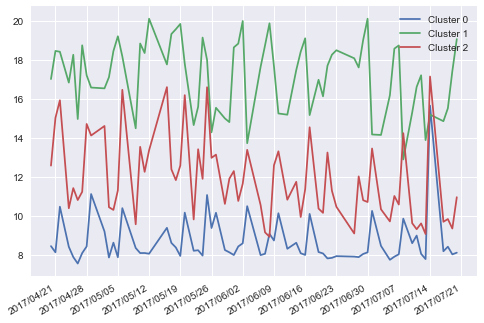

In [168]:
import matplotlib.dates as mdates

x = transposedIF.transpose().index.values.tolist()[:-8]
c0 = transposedIF.loc[transposedIF['Cluster'] == 0].transpose().mean(1).values.tolist()[:-8]
c1 = transposedIF.loc[transposedIF['Cluster'] == 1].transpose().mean(1).values.tolist()[:-8]
c2 = transposedIF.loc[transposedIF['Cluster'] == 2].transpose().mean(1).values.tolist()[:-8]
for i in range(len(x)):
    x[i] = datetime.strptime(str(x[i]),'%Y-%m-%d %H:%M:%S').date() 
    
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 7))
cluster0, = plt.plot(x,c0, label =  'Cluster 0')
cluster1, = plt.plot(x,c1, label =  'Cluster 1')
cluster2, = plt.plot(x,c2, label =  'Cluster 2')
plt.legend(handles=[cluster0,cluster1,cluster2])
plt.gcf().autofmt_xdate()
plt.show()


If we look at a certain moment in July, we will realize that there's a day where the peak hour of clusters 0 and 1 is considerably greater than the average. 

In [175]:
x[c0.index(max(c0))]

datetime.date(2017, 7, 14)

It's the Bastille Day in France!

In [176]:
by_hour = transposedIF.groupby(['Cluster', transposedIF.index]).mean()
by_hour

Day          2017-04-20  2017-04-21  2017-04-22  2017-04-24  2017-04-25  \
Cluster                                                                   
0       1      6.233333    6.150000    8.816667    6.066667    6.150000   
        3      6.400000    6.016667    6.900000    9.066667    6.800000   
        4     12.500000   11.900000   14.150000    9.400000    8.750000   
        11     9.300000    9.566667   10.250000    8.233333    9.900000   
        20    12.566667   10.250000   10.650000   10.116667    9.650000   
        23     8.650000    8.066667   10.000000    8.650000    8.416667   
        39     8.316667    8.566667   19.066667    8.316667    8.200000   
        40     8.316667    8.366667    8.650000    7.750000    7.566667   
        41     7.733333    7.316667    9.066667    8.066667    7.500000   
        43     7.616667    8.250000   12.000000    7.750000    7.750000   
        44     7.083333    7.566667    7.900000    7.900000    7.566667   
        45     7.150000    7.366667   10.783333    7.900000    7.500000   
        47     8.316667    8.400000   10.650000    8.066667    8.566667   
        48     8.000000    7.750000   11.866667    7.533333    7.200000   
        49     7.400000    7.633333   11.000000    7.150000    7.566667   
        52     7.733333    7.700000    9.366667    7.750000    7.750000   
        53     8.250000    8.533333    8.533333    8.066667    8.250000   
        55     8.950000    8.816667    9.600000    8.066667    7.500000   
        87    13.566667    7.750000   16.700000   17.000000    8.700000   
        104    7.666667    7.700000   10.066667    7.900000    7.116667   
        105    7.533333    8.000000    8.316667    8.066667    8.000000   
        107    7.733333    7.566667    7.566667    7.400000    7.750000   
        108    7.400000    7.866667    9.000000    7.400000    7.400000   
1       5     19.566667   20.566667   20.316667   19.250000   19.400000   
        8     20.066667   20.366667   13.150000   20.066667   20.066667   
        12    20.400000   20.416667   20.750000   20.400000   20.400000   
        14    20.250000   20.250000   20.150000   19.566667   19.566667   
        21     8.400000    7.750000   16.150000    8.316667    9.250000   
        28    20.200000   20.566667   20.400000   20.400000   20.000000   
        50     7.233333   17.200000   16.366667   14.566667   17.233333   
        79    20.033333   20.566667   20.066667   12.133333   20.200000   
2       2     10.133333   17.250000   16.150000   14.166667   12.116667   
        6     20.250000   20.366667   20.566667    9.816667    8.566667   
        7     19.816667   19.900000   12.633333    9.166667   20.066667   
        10    19.566667   12.250000   10.066667   11.566667   10.066667   
        13     8.650000   20.150000   20.500000    8.566667    8.166667   
        16    14.033333    8.566667   15.066667    8.900000    8.900000   
        18     9.233333   12.816667   14.733333    8.900000    8.900000   
        19     9.866667   12.816667   15.200000    9.566667   12.000000   
        22     9.000000   16.233333   20.033333   10.366667   18.333333   
        25     9.283333   16.366667   10.900000   15.000000   10.166667   
        27     8.566667    8.566667   19.400000    8.316667    8.416667   

Day          2017-04-26  2017-04-27  2017-04-28  2017-04-29  2017-05-02  \
Cluster                                                                   
0       1      6.066667    6.250000    6.250000   14.000000   15.500000   
        3      6.500000    6.400000   12.000000   15.400000   12.650000   
        4      9.366667    9.066667   10.566667   13.000000   12.316667   
        11     9.566667   10.000000    9.500000   10.400000   11.150000   
        20     0.616667   12.466667   10.466667   10.900000   11.000000   
        23     8.066667    8.400000   12.833333    1.816667   11.000000   
        39     8.400000    8.583333    8.400000   14.066667    8.566667   
        40     7.750000 

In [173]:
import os
import folium
import json
from folium.plugins import MarkerCluster

jsonFile = open('infocomplete.txt')
jsonFileString = jsonFile.read()

dataParkingsStringList = jsonFileString[3:].split(',\n')
listJsonData = []
for jsondata in dataParkingsStringList:
    dataDict = json.loads(jsondata)
    listJsonData.append(dataDict)
l2 = []
l1 = []
l0 = []
for index, row in transposedIF.iterrows():
    if row['Cluster'] == 2:
        l2.append(str(index))
    if row['Cluster'] == 1:
        l1.append(str(index))
    if row['Cluster'] == 0:
        l0.append(str(index))
print(l0,l1,l2)
m = folium.Map(location=[45.7484600,4.8467100], zoom_start=14)

for dictData in listJsonData:
    if dictData['properties']['idparkingcriter'] in l2:
        [lon, lat] = dictData['geometry']['coordinates']
        popupText = "ID : " + dictData['properties']['idparkingcriter'] + ". Capacity: " + dictData['properties']['capacite'] + ". Fermeture: " + dictData['properties']['fermeture']

        marker = folium.Marker(
            location=[lat, lon],
            popup=popupText,
            icon=folium.Icon(color='red')
        )

        m.add_child(marker)
        
    if dictData['properties']['idparkingcriter'] in l1:
        [lon, lat] = dictData['geometry']['coordinates']
        popupText = "ID : " + dictData['properties']['idparkingcriter'] + ". Capacity: " + dictData['properties']['capacite'] + ". Fermeture: " + dictData['properties']['fermeture']

        marker = folium.Marker(
            location=[lat, lon],
            popup=popupText,
            icon=folium.Icon(color='green')
        )

        m.add_child(marker)

    if dictData['properties']['idparkingcriter'] in l0:
        [lon, lat] = dictData['geometry']['coordinates']
        popupText = "ID : " + dictData['properties']['idparkingcriter'] + ". Capacity: " + dictData['properties']['capacite'] + ". Fermeture: " + dictData['properties']['fermeture']

        marker = folium.Marker(
            location=[lat, lon],
            popup=popupText
        )

        m.add_child(marker)
m.save(os.path.join('ClusterParking.html'))
m

['108', '1', '3', '4', '11', '20', '23', '39', '40', '41', '43', '44', '45', '47', '48', '49', '52', '53', '55', '105', '104', '107', '87'] ['79', '5', '8', '12', '14', '21', '28', '50'] ['2', '6', '7', '10', '13', '16', '18', '19', '22', '25', '27']
